![](https://drive.google.com/uc?export=view&id=1ai6wku_Lh5l-yuZ_8axuwRYDLHEHkNpn)

# EE7390: Pattern Recognition and Machine Learning

*  MD AAMIR SOHAIL
*  EE16BTECH11021



Modelling Infectious Disease:

***COMPARTMENTAL MODELS*** in Epidemiology

![SIR Model](https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/SIR_Flow_Diagram.svg/800px-SIR_Flow_Diagram.svg.png?1589297819541)



*   **S**usceptible (can be infected, 'Healthy')
*   **I**nfected
*   **R**ecovered (were infected, immnune to the disease)


***Can it model real-world infectious diseases? The answer is NO!!!.*** 
Let’s change that!

## Introducing New Compartments

1. Exposed- Many diseases have an incubation period before being infectious during which the host cannot yet spread the disease. 
2. Death- It can be further decomposed into *Natural Death* or *Death by disease*.
3. Asymptomatic infectious- Infected population can be both *Asymptomatic* (not showing symptoms but are infectious !!!) or *Symptomatic*. 
4. Vital Dynamics: Birth and Change in population (immigration or inter-state movement)
5. Pathogen: Amount of Pathogen present during interaction of human beings at time t. 

### SEIRD  Model:

*   **S**usceptible (can be infected, 'Healthy')
*   **E**xposed (infectious but can't spread disease, 'Healthy')
*   **I**nfected (infectious and can spread disease)
*   **R**ecovered (were infected, immnune to the disease)
*   **D**eath (deceased)

![SIRD Model](https://drive.google.com/uc?export=view&id=1b6fE5ezain5I97mKZRNBNNeYJR6KLgJs)

> Time-Dependent Variables
*   **N(t)**: total Population on day t
*   **S(t)**: number of people susceptible on day t
*   **E(t)**: number of people exposed on day t
*   **I(t)**: number of people infected on day t
*   **R(t)**: number of people recovered on day t
*   **D(t)**: number of people dead on day t

> Model Parameters
*   D: # of days an infected person has disease 
*   $\alpha$: fatality rate
*   $\beta$: expected amount of people infected person infects per day
*   $\gamma$: recovery rate (1/D)
*   $\delta$: inverse of incubation period
*   $\rho$: deceased rate 
*   $R_o (=\beta/\gamma)$: Reproduction Number (expected number of person an infected person infects during his disease period)

>**SEIRD Model:**
* $ \frac{dS(t)}{dt} = - \beta \cdot \frac{S}{N} \cdot \textit I $
* $ \frac{dE(t)}{dt} =  \beta \cdot \frac{S}{N} \cdot \textit I \quad - \delta \cdot E
$
* $ \frac{dI(t)}{dt} = \delta \cdot E \quad - \rho \cdot \alpha \cdot \textit I \quad - \gamma \cdot (1-\alpha) \cdot \textit I 
$
* $ \frac{dR(t)}{dt} = \gamma \cdot (1-\alpha) \cdot \textit I$
* $ \frac{dD(t)}{dt} = \rho \cdot \alpha \cdot \textit I$

#### Imports Libraries

In [ ]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()
!pip install lmfit
import lmfit

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Initializing Color Array to be used across the analysis
color_arr = px.colors.qualitative.Dark24

# Imports required
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta, datetime

  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=115105 sha256=e3a2b0f6c60fb698141c4e2e7998f102d3ddd8e9f565ee8465b557aa6d64dc9c
  Stored in directory: C:\Users\MD.AAMIR SOHAIL\AppData\Local\pip\Cache\wheels\c0\47\fb\8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


#### SEIRD Modelling

In [ ]:
def model_1(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

def plotSEIRD(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

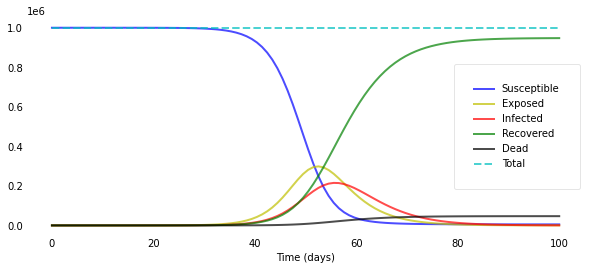

In [0]:
N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D # rate of recovery
a = 5.0 # incubation period (days)
delta = 1.0 / a  # rate of becoming infectious

### Expected number of people an infected person infect during his infection period
R_0 = 5 ### Basic Reproduction number

### Beta (expected number of people an infected person infect per day)
beta = R_0 * gamma  # R_0 = beta/gamma 

alpha = 0.1  # 10% death rate
rho = 1/9  # 1/ x-days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

''' SOLVING SERID MODEL'''
t = np.linspace(0, 100, 100) # Grid of time points (in days)
x_init = S0, E0, I0, R0, D0 # Initial number of the compartments

# Integrate the SIR equations over the time grid, t.
solution = odeint(model_1, x_init, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = solution.T

### Plotting
plotSEIRD(t,S,E,I,R,D)

#### Basic Reproductivity number

$R_0 = \beta/\gamma$, where $\beta$ is the expected number of people an infected person infects.

For e.g. If the probability of infecting is $20\%$, infected person meets 10 person (avg.) per day.
Then, $\beta = 2$ person per day. 
If the recovering period of the disease if 10 days.
Then, infected person has infected $2*10 = 20$ persons.  

> $R_0 \Longleftrightarrow$ Lockdown, Social Distancing



![](https://assets.weforum.org/editor/9nDC50El-gHfivr6aKgZYxWf4ymER_URy15IK5f4ss0.png)

SOURCE: World Economic Forum (Flattening The Curve)

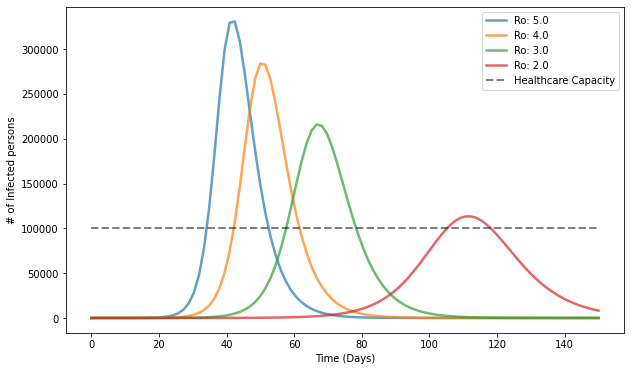

In [0]:
### Expected number of people an infected person infect during his infection period
R_0 = np.array([5.0, 4.0, 3.0, 2.0]) ### Basic Reproduction number
N = 1_000_000
D = 5.0 # infections lasts four days
gamma = 1.0 / D # rate of recovery
a = 2.0 # incubation period (days)
delta = 1.0 / a  # rate of becoming infectious
alpha = 0.1  # 10% death rate
rho = 1/6  # 1/ x-days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

''' SOLVING SERID MODEL'''
t = np.linspace(0, 150, 100) # Grid of time points (in days)
x_init = S0, E0, I0, R0, D0 # Initial number of the compartments

f, ax = plt.subplots(1,1,figsize=(10,6))
for r0 in R_0:
  ### Beta (expected number of people an infected person infect per day)
  beta = r0 * gamma  # R_0 = beta/gamma 
  # Integrate the SIR equations over the time grid, t.
  solution = odeint(model_1, x_init, t, args=(N, beta, gamma, delta, alpha, rho))
  S, E, I, R, D = solution.T

  ### Plotting
  ax.plot(t, I, alpha=0.7, linewidth=2.5, label='Ro: '+str(r0))

# ax.plot(t, S+E+I+R+D, 'k--', alpha=0.5, linewidth=2, label='Total Population')

### n_P_per_Bed: avg. number of persons per bed 
n_P_per_Bed = 10
ax.plot(t, (S+E+I+R+D)/n_P_per_Bed, 'k--', alpha=0.5, linewidth=2, label='Healthcare Capacity')
ax.legend()
ax.set_xlabel('Time (Days)')
ax.set_ylabel('# of Infected persons')
plt.show()

![](https://assets.weforum.org/editor/OvFhzpR-LBnXhkCKJQCS-esRaIXokJd70JBjHA0tgNs.gif)

SOURCE: World Economic Forum (Flattening The Curve)

#### Fitting SEIRD Model to India Coronavirus Data

##### Downloading datasets into respective data frames 

In [0]:
'''Links to raw files for Covid-19 dataset provided by CSSEGIS JHU'''

confimed_cases_file_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
death_cases_file_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
recovered_cases_file_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
country_cases_file_link = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv"

'''Creating Dataframes'''
confirmed_df = pd.read_csv(confimed_cases_file_link)
deaths_df = pd.read_csv(death_cases_file_link)
recovered_df = pd.read_csv(recovered_cases_file_link)

cases_country_df = pd.read_csv(country_cases_file_link)

##### Data Preprocessing

In [0]:
confirmed_df = confirmed_df.replace(np.nan, '', regex=True)
confirmed_df.drop(['Province/State','Lat','Long'],axis=1,inplace=True)
deaths_df = deaths_df.replace(np.nan, '', regex=True)
deaths_df.drop(['Province/State','Lat','Long'],axis=1,inplace=True)
recovered_df = recovered_df.replace(np.nan, '', regex=True)
recovered_df.drop(['Province/State','Lat','Long'],axis=1,inplace=True)
cases_country_df = cases_country_df.replace(np.nan, '', regex=True)

##### Visualising Global outbreak status

In [0]:
'''Confirmed'''
confirmed_df_summary = confirmed_df.sum()

fig_1 = go.Figure(data=go.Scatter(x=confirmed_df_summary.index, y = confirmed_df_summary.values, mode='lines+markers'))
fig_1.update_layout(title='Total Coronavirus Confirmed Cases (Globally)',
                  yaxis_title='Confirmed Cases', xaxis_tickangle = 315 )
fig_1.show()

'''Recovered'''
recovered_df_summary = recovered_df.sum()

fig_2 = go.Figure(data=go.Scatter(x=recovered_df_summary.index, y = recovered_df_summary.values, mode='lines+markers'))
fig_2.update_layout(title='Total Coronavirus Recovered Cases (Globally)',
                  yaxis_title='Confirmed Cases', xaxis_tickangle = 315 )
fig_2.show()

'''Deaths'''
deaths_df_summary = deaths_df.sum()

fig_2 = go.Figure(data=go.Scatter(x=deaths_df_summary.index, y = deaths_df_summary.values, mode='lines+markers'))
fig_2.update_layout(title='Total Coronavirus Deaths Cases (Globally)',
                  yaxis_title='Confirmed Cases', xaxis_tickangle = 315 )
fig_2.show()

##### COVID19 PANDEMIC: India Statistics 

In [0]:
print("Confirmed Cases: \n")
print(confirmed_df.loc[confirmed_df['Country/Region'] == 'India'])

print("\n Recovered Cases: \n")
print(recovered_df.loc[recovered_df['Country/Region'] == 'India'])

print("\n Deaths Cases: \n")
print(deaths_df.loc[deaths_df['Country/Region'] == 'India'])

Confirmed Cases: 

    Country/Region  1/22/20  1/23/20  ...  5/14/20  5/15/20  5/16/20
131          India        0        0  ...    81997    85784    90648

[1 rows x 117 columns]

 Recovered Cases: 

    Country/Region  1/22/20  1/23/20  ...  5/14/20  5/15/20  5/16/20
125          India        0        0  ...    27969    30258    34224

[1 rows x 117 columns]

 Deaths Cases: 

    Country/Region  1/22/20  1/23/20  ...  5/14/20  5/15/20  5/16/20
131          India        0        0  ...     2649     2753     2871

[1 rows x 117 columns]


##### Visualising Covid-19 Case Trend in India- 22/03/2020 Onwards 


In [0]:
def draw_plot(ts_array, ts_label, title, colors, mode_size, line_size, x_axis_title , y_axis_title, tickangle = 0, yaxis_type = "", additional_annotations=[]):
    # initialize figure
    fig = go.Figure()
    # add all traces
    for index, ts in enumerate(ts_array):
        fig.add_trace(go.Scatter(x=ts.index,
                                 y = ts.values,
                                 name = ts_label[index],
                                 line=dict(color=colors[index], width=line_size[index]),connectgaps=True,))
    # base x_axis prop.
    x_axis_dict = dict(showline=True, 
                       showgrid=True, 
                       showticklabels=True, 
                       linecolor='rgb(204, 204, 204)', 
                       linewidth=2,
                       ticks='outside',
                       tickfont=dict(family='Arial',size=12,color='rgb(82, 82, 82)',))
    # setting x_axis params
    if x_axis_title:
        x_axis_dict['title'] = x_axis_title
    
    if tickangle > 0:
        x_axis_dict['tickangle'] = tickangle
    
    # base y_axis prop.
    y_axis_dict = dict(showline = True,
                       showgrid = True,
                       showticklabels=True,
                       linecolor='rgb(204, 204, 204)',
                       linewidth=2,)
    # setting y_axis params
    if yaxis_type != "":
        y_axis_dict['type'] = yaxis_type
    
    if y_axis_title:
        y_axis_dict['title'] = y_axis_title
    
    #updating the layout
    fig.update_layout(xaxis = x_axis_dict,
                      yaxis = y_axis_dict,
                      autosize=True,
                      margin=dict(autoexpand=False,l=100,r=20,t=110,),
                     )

    # base annotations for any graph
    annotations = []
    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05, xanchor='left', yanchor='bottom',
                                  text=title,
                                  font=dict(family='Arial',size=16,color='rgb(37,37,37)'),showarrow=False))
    # adding annotations in params
    if len(additional_annotations) > 0:
        annotations.append(additional_annotations)
    
    #updating the layout
    fig.update_layout(annotations=annotations)

    return fig

In [0]:
confirmed_India = confirmed_df[confirmed_df['Country/Region']=="India"]
deaths_India = deaths_df[deaths_df['Country/Region']=="India"]
recovered_India = recovered_df[recovered_df['Country/Region']=="India"]

confirmed_India = confirmed_India.drop(['Country/Region'],axis=1).reset_index(drop=True).sum()
deaths_India = deaths_India.drop(['Country/Region'],axis =1).reset_index(drop=True).sum()
recovered_India = recovered_India.drop(['Country/Region'],axis =1).reset_index(drop=True).sum()

### Active =  Confirmed - Recovered - Deaths
active_India = pd.Series(
    data=np.array(
        [x1 - x2 - x3  for (x1, x2, x3) in zip(
            confirmed_India.values,deaths_India.values, recovered_India.values)
        ] 
    ), 
    index= confirmed_India.index
)

'''Covid-19 Case Trend in India- 12/03/2020 Onwards '''
India_array = [confirmed_India[50:], active_India[50:], recovered_India[50:], deaths_India[60:]]
labels = ['Confirmed', 'Active', 'Recovered', 'Deaths']
colors = [color_arr[5],  color_arr[0], color_arr[2], color_arr[3]]
mode_size = [8, 8, 12, 8]
line_size = [2, 2, 4, 2]

# Calling the draw_plot function defined above
fig_4 = draw_plot(ts_array = India_array, 
                  ts_label = labels , 
                  title = "Covid-19 Case Trend in INDIA",
                  colors = colors, mode_size = mode_size, 
                  line_size = line_size , 
                  x_axis_title = "Date" , 
                  y_axis_title = "Case Count", 
                  tickangle = 315, 
                  yaxis_type = "", additional_annotations=[])

fig_4.show()

##### Modeling & Prediction (SEIRD)

###### SEIRD Model

In [0]:
#### SEIRD Modelling
class Learner(object):
    def __init__(self, country, cost_func, start_date, predict_range, N, s_0, e_0, i_0, r_0,d_0):
        self.country = country
        self.cost_func = cost_func
        self.start_date = start_date
        self.predict_range = predict_range
        self.N = N
        self.s_0 = s_0
        self.e_0 = e_0
        self.i_0 = i_0
        self.r_0 = r_0
        self.d_0 = d_0
        
    #### Loading Data of Country X, from Start Date: Y
    def load_confirmed(self, country):
        df = pd.read_csv(confimed_cases_file_link)
        df = df.drop(['Province/State'],axis =1)
        country_conf_df = df[df['Country/Region'] == country]
        return country_conf_df.iloc[0].loc[self.start_date:]


    def load_recovered(self, country):
        df = pd.read_csv(recovered_cases_file_link)
        df = df.drop(['Province/State'],axis =1)
        country_recv_df = df[df['Country/Region'] == country]
        return country_recv_df.iloc[0].loc[self.start_date:]


    def load_dead(self, country):
        df = pd.read_csv(death_cases_file_link)
        df = df.drop(['Province/State'],axis =1)
        country_deaths_df = df[df['Country/Region'] == country]
        return country_deaths_df.iloc[0].loc[self.start_date:]
    
    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values
      
    def predict(self, alpha, beta, gamma, delta, rho, infected, recovered, death, country,N, s_0, e_0, i_0, r_0,d_0):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        """
        new_index = self.extend_index(infected.index, self.predict_range)
        size = len(new_index)

        def SEIRD(t, y):
            S, E, I, R, D = y[0], y[1], y[2], y[3], y[4]
            ### Update:
            dSdt = -beta*S*I/N
            dEdt = beta*S*I/N - delta*E
            dIdt = delta*E - (1-alpha)*gamma*I-alpha*rho*I
            dRdt = (1-alpha)*gamma*I
            dDdt = alpha*rho*I
            return [dSdt, dEdt, dIdt, dRdt, dDdt]
        
        extended_active = np.concatenate((infected.values, [None] * (size - len(infected.values))))
        extended_recovered = np.concatenate((recovered.values, [None] * (size - len(recovered.values))))
        extended_death = np.concatenate((death.values, [None] * (size - len(death.values))))
        return new_index, extended_active, extended_recovered, extended_death, solve_ivp(SEIRD, [0, size], [s_0,e_0,i_0,r_0,d_0], t_eval=np.arange(0, size, 1))
    
    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        recovered = self.load_recovered(self.country)
        death = self.load_dead(self.country)
        active = (self.load_confirmed(self.country) - recovered - death)
        
        optimal = minimize(
            cost_func, 
            [0.001, 0.001, 0.001, 0.001, 0.001], 
            args=(active, recovered, death, self.N, self.s_0, self.e_0, self.i_0, self.r_0,self.d_0), 
            method='L-BFGS-B', 
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4), (0.00000001, 0.4)]
        )
        print(optimal)
        alpha, beta, gamma, delta, rho = optimal.x
        new_index, extended_active, extended_recovered, extended_death, prediction = self.predict(alpha, beta, gamma, delta, rho, 
                                                                                                  active, recovered, death, 
                                                                                                  self.country, 
                                                                                                  self.N, 
                                                                                                  self.s_0, 
                                                                                                  self.e_0, 
                                                                                                  self.i_0, 
                                                                                                  self.r_0, 
                                                                                                  self.d_0)
        df = pd.DataFrame({'Infected data': extended_active, 
                           'Recovered data': extended_recovered, 
                           'Death data': extended_death,
                           'Susceptible': prediction.y[0], 
                           'Exposed': prediction.y[1], 
                           'Infected': prediction.y[2], 
                           'Recovered': prediction.y[3], 
                           'Death':prediction.y[4]}, 
                          index=new_index)
        
        df.to_csv(f"{self.country}.csv")
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        print(f"country={self.country}, alpha={alpha:.8f},beta={beta:.8f}, gamma={gamma:.8f}, delta={delta:.8f}, rho={rho:.8f},r_0:{(beta/gamma):.8f}")
        fig.savefig(f"{self.country}.png")
        
        return df, fig

'''Defining Cost Function'''
def cost_func(parameters, active, recovered, death, N, s_0, e_0, i_0, r_0,d_0):
    size = len(active)
    alpha, beta, gamma, delta, rho = parameters
    ''' RMSE '''
    def SEIRD(t, y):
            S, E, I, R, D = y[0], y[1], y[2], y[3], y[4]
            ### Update:
            dSdt = -beta*S*I/N
            dEdt = beta*S*I/N - delta*E
            dIdt = delta*E - (1-alpha)*gamma*I-alpha*rho*I
            dRdt = (1-alpha)*gamma*I
            dDdt = alpha*rho*I
            return [dSdt, dEdt, dIdt, dRdt, dDdt]

    solution = solve_ivp(SEIRD, [0, size], [s_0,e_0, i_0,r_0,d_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l_infected = np.sqrt(np.mean((solution.y[2] - active)**2))
    l_recovered = np.sqrt(np.mean((solution.y[3] - recovered)**2))
    l_death = np.sqrt(np.mean((solution.y[4] - death)**2))
    w1, w2, w3 = 0.3, 0.4, 0.3
    return w1*l_infected + w2*l_recovered + w3*l_death

###### Prediction for India

      fun: 1367.0327736705779
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([   3.91946742,  -19.03724751,   11.97738584, -206.61025246,
          1.19405286])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 612
      nit: 71
   status: 0
  success: True
        x: array([0.03398119, 0.15600897, 0.04272055, 0.4       , 0.12458411])
country=India, alpha=0.03398119,beta=0.15600897, gamma=0.04272055, delta=0.40000000, rho=0.12458411,r_0:3.65184831


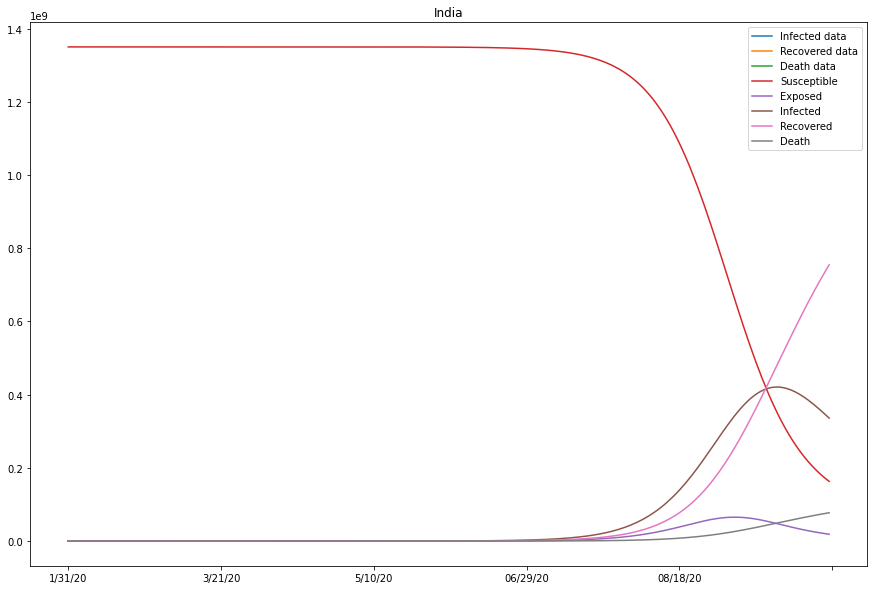

In [0]:
total_population = 1_350_000_000
e_0 = 15
india_learner = Learner(country="India", 
                        cost_func = cost_func, 
                        start_date ='1/31/20',
                        predict_range=250, 
                        N = total_population, 
                        s_0 = total_population-e_0, 
                        e_0 = e_0, 
                        i_0= 0, 
                        r_0 = 0, 
                        d_0 = 0)

india_SEIRD , seird_fig = india_learner.train()

In [0]:
#### CLOSE LOOK-UP at the graph
def plot_sir_prediction(title, df_sir, remove_series=[],yaxis_type="", yaxis_title=""):
    fig = go.Figure()
    title = title
    labels = ['Infected data','Recovered data', 'Death data', 'Susceptible','Exposed','Infected','Recovered','Death']
    colors = [color_arr[0], color_arr[8], color_arr[2], color_arr[3],color_arr[7], color_arr[16], color_arr[10], color_arr[1]]
    line_size = [2, 2, 2, 2, 2, 2, 2, 2]
    
    for index, data_series in enumerate(labels):
        if data_series not in remove_series:
            fig.add_trace(go.Scatter(x=df_sir.index, 
                                           y = df_sir[data_series], 
                                           name = labels[index],
                                           line=dict(
                                               color=colors[index], 
                                               width=line_size[index]),
                                           connectgaps=True,))
    xaxis= dict(title = "Date",
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickangle = 280,
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',),)
    yaxis = dict(
        title = "Case Count",
        showline = True,
        showgrid = True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,)
    
    if yaxis_type!="":
        yaxis['type'] = yaxis_type
    
    if yaxis_title !="":
        yaxis['title'] = yaxis_title
    
    fig.update_layout(
        xaxis = xaxis,
        yaxis = yaxis,
        autosize=True,
        margin=dict(autoexpand=True,l=100,r=20,t=110,),
        showlegend=True)

    annotations = []

    # Title
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text=title,
                              font=dict(family='Arial',
                                        size=16,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

    fig.update_layout(annotations=annotations)
    
    return fig
    
# To remove the "Susceptible" series just pass the series name to remove_series
fig = plot_sir_prediction(
    title="SIR Model --  Covid-19 Transmission -- Prediction -- INDIA", 
    df_sir= india_SEIRD[50:150],
    remove_series=['Susceptible'])

fig.show()

fig = plot_sir_prediction(
    title="SIR Model --  Covid-19 Transmission -- Prediction -- INDIA", 
    df_sir= india_SEIRD[50:110],
    remove_series=['Susceptible','Exposed'])

fig.show()

#### Closer Look at the Model for real-world pandemic modelling
As we can see, infected cases has a huge error associated with the predcited counterparts.
Realisitically, not only compartments changes over time but also $R_0, \alpha $ etc.! We saw nationwide lockdowns and other control measures reduce the number of people an infected person infects. Naturally, to get closer to modelling real-world developments, we have to make our variables change over time.

##### Time-Dependent $R_0$

###### 1. Lockdown

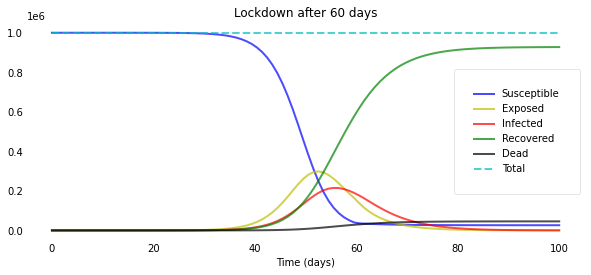

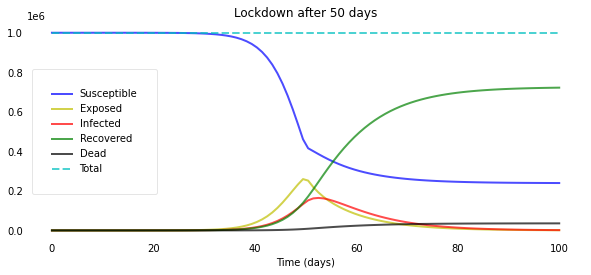

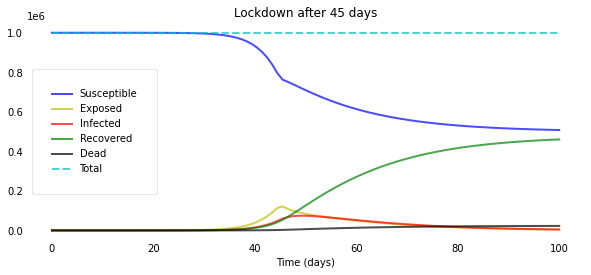

In [0]:
def model_2(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D # rate of recovery
a = 5.0 # incubation period (days)
delta = 1.0 / a  # rate of becoming infectious
alpha = 0.1  # 10% death rate
rho = 1/9  # 1/ x-days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

### L: After L days of the outbreak lockdown invoked 
L = np.array([60, 50, 45])

for lockdown in L:
  ### Expected number of people an infected person infect during his infection period
  ### Basic Reproduction number
  def R_0(t):
      return 5.0 if t < lockdown else 0.9

  ### Beta (expected number of people an infected person infect per day)
  def beta(t):
      return R_0(t) * gamma

  ''' SOLVING SERID MODEL '''
  t = np.linspace(0, 100, 100) # Grid of time points (in days)
  x_init = S0, E0, I0, R0, D0 # Initial number of the compartments

  # Integrate the SIR equations over the time grid, t.
  solution = odeint(model_t, x_init, t, args=(N, beta, gamma, delta, alpha, rho))
  S, E, I, R, D = solution.T

  ### Plotting
  plotSEIRD(t,S,E,I,R,D,lockdown)

###### 2. Logistic $R_0$

$R_0(t) = \frac{R_{0_{start}}- R_{0_{end}}}{1+e^{-k(t_0 - t)}} + R_{0_{end}}$

where,
*   $R_{0_{start}}$ and $R_{0_{end}}$ are the extremums of the $R_0$.
*   $t_0$ is the date of the steepest decline, 'lockdown date'.
*   k: rate of declining $R_0$



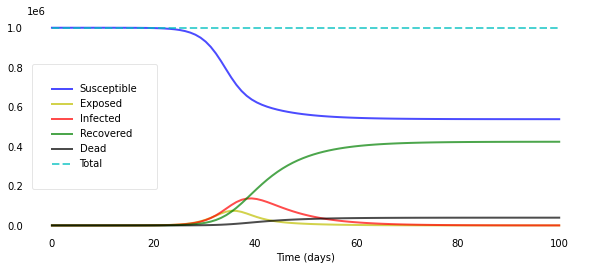

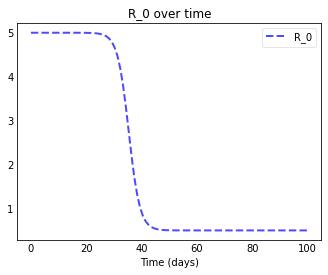

In [0]:
R_0_start, k, t0, R_0_end = 5.0, 0.5, 35, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+t0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

# Integrate the SIR equations over the time grid, t.
solution = odeint(model_t, x_init, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = solution.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values

### Plotting
plotseird(t, S, E, I, R, D, R0=R0_over_time)

##### Age-Dependent fatality rate $\alpha(t)$

$\alpha(t) = s \cdot I(t)/N + \alpha_{OPT}$

where 
* $\alpha_{OPT}$ is the optimal fatality rate,
* s controls the influence of age-dependent Infected cases.

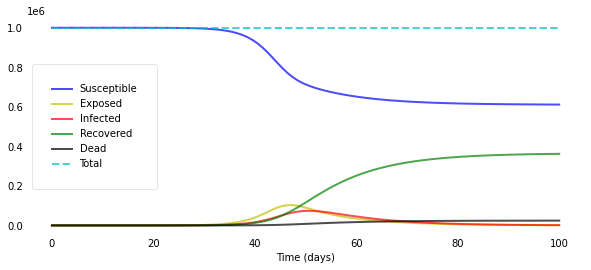

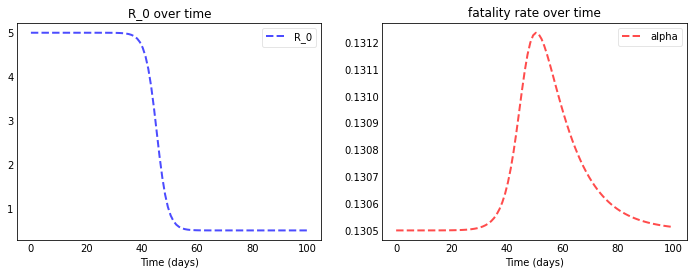

In [0]:
def model_3(y, t, N, beta, gamma, delta, alpha_opt, rho):
    S, E, I, R, D = y
    def alpha(t):
      return s * I/N + alpha_opt
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha(t)) * gamma * I - alpha(t) * rho * I
    dRdt = (1 - alpha(t)) * gamma * I
    dDdt = alpha(t) * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

N = 1_000_000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days

R_0_start, k, x0, R_0_end = 5.0, 0.5, 45, 0.5

def logistic_R_0(t):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def beta(t):
    return logistic_R_0(t) * gamma

alpha_by_agegroup = {"0-29": 0.01, "30-59": 0.05, "60-89": 0.2, "89+": 0.3}
proportion_of_agegroup = {"0-29": 0.3, "30-59": 0.35, "60-89": 0.25, "89+": 0.2}
s = 0.01
alpha_opt = sum(alpha_by_agegroup[i] * proportion_of_agegroup[i] for i in list(alpha_by_agegroup.keys()))

rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

t = np.linspace(0, 100, 100) # Grid of time points (in days)
x_init = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
solution = odeint(model_3, x_init, t, args=(N, beta, gamma, delta, alpha_opt, rho))
S, E, I, R, D = solution.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
Alpha_over_time = [s * I[i]/N + alpha_opt for i in range(len(t))]  # to plot alpha over time

plotSEIRD(t, S, E, I, R, D, R0=R0_over_time, Alpha=Alpha_over_time)

#### Extended SEIRD Model 

![](https://drive.google.com/uc?export=view&id=1Cs5Ft3BUOsUupc7_T9qMXxR8ebPgi6Ss)

###### Reading Supplement Data (from [UN Data](https://data.un.org/))

In [0]:
# read the data
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")
covid_data = pd.read_csv("https://tinyurl.com/t59cgxn", parse_dates=["Date"], skiprows=[1])
covid_data["Location"] = covid_data["Country/Region"]

# create some dicts for fast lookup
# 1. beds
beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
# 2. agegroups
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))

# store the probabilities collected
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

###### Plotting

In [0]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
      print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")
    
    f = plt.figure(figsize=(20,4))
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax1.spines[spine].set_visible(False)
    
    # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='Avg. CFR')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='Daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='Avg. CFR')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='Daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text(' Case Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax2.spines[spine].set_visible(False)

    # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='per day death increment')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='per day death increment')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity ")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax3.spines[spine].set_visible(False)

    plt.show();

<Figure size 432x288 with 0 Axes>

###### Extended Model

In [0]:
def ext_SEIRD(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds):
    S, E, I, C, R, D = y

    dSdt = -beta(t) * I * S / N
    dEdt = beta(t) * I * S / N - sigma * E
    dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
    dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
    dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt
  
gamma = 1.0/9.0
sigma = 1.0/3.0

def logistic_R_0(t, R_0_start, k, x0, R_0_end):
    return (R_0_start-R_0_end) / (1 + np.exp(-k*(-t+x0))) + R_0_end

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(ext_SEIRD, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds))
    S, E, I, C, R, D = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

###### Lockdown, Fatality rate, Healthcare Resources and Deaths in Italy.

In [0]:
# Parameters
data = covid_data[covid_data["Location"] == "Italy"]["Value"].values[::-1]
agegroups = agegroup_lookup["Italy"]
beds_per_100k = beds_lookup["Italy"]
outbreak_shift = 30 
# format: {parameter: (initial guess, minimum value, max value)}
params_init_min_max = {"R_0_start": (3.0, 2.0, 5.0), "k": (2.5, 0.01, 5.0), "x0": (90, 0, 120), "R_0_end": (0.9, 0.3, 3.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.5, 0.05, 0.8),
                       "s": (0.003, 0.001, 0.01)}  

days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = y_data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array

def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s)
    return ret[6][x]

mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()
fit_method = "leastsq"

result = mod.fit(y_data, params, method="least_squares", x=x_data)   
# result.best_values                    

###### Analysing COVID19 outbreak in Italy

Prediction for Italy
percentage going to ICU: 6.9913426536772505; percentage dying in ICU: 59.97050997344494


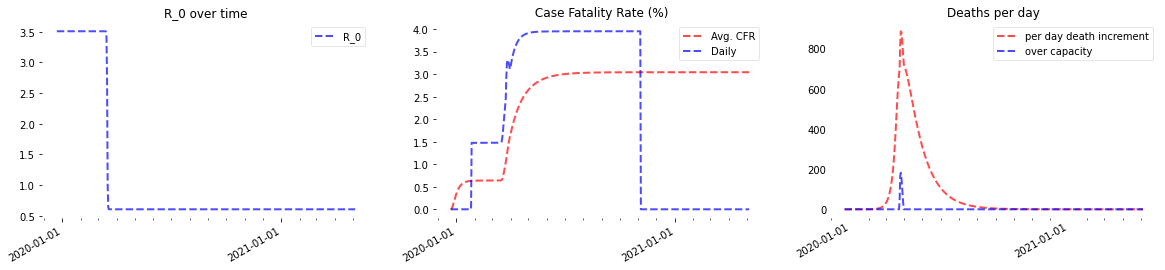

In [0]:
full_days = 500
first_date = np.datetime64(covid_data.Date.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for Italy")
plotter(*Model(full_days, agegroup_lookup["Italy"], beds_lookup["Italy"], **result.best_values), x_ticks=x_ticks);

![](https://drive.google.com/uc?export=view&id=1SU-yBxeGFu_HPGAXy4xSZ4dzQI12Lqx4)

#### **FUTURE WORK**

*   Incorporate time dependent with parameters SEIRD Model 
*   Include left compartments
*   Use Deep Learining Technique to predict outbreak.



#### Reference Links:

1. https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge
2. https://www.lewuathe.com/COVID-19-dynamics-with-sir-model.html
3. https://github.com/Lewuathe/COVID19-SIR
4. https://in.springboard.com/blog/data-modelling-covid/
5. https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
6. https://towardsdatascience.com/infectious-disease-modelling-part-i-understanding-sir-28d60e29fdfc
7. https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4
8. https://towardsdatascience.com/infectious-disease-modelling-fit-your-model-to-coronavirus-data-2568e672dbc7
9. https://www.worldometers.info/coronavirus/
10. https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6